In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
path = os.path.abspath(os.path.join(os.getcwd(),".."))
print(path)
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from dynamics_networks import DynamicsNetwork, DynamicsParamsOptimizer, EncoderDynamicsNetwork, EncoderDecoderDynamicsNetwork, VAEDynamicsNetwork
from rl.policy_networks import DPG_PolicyNetwork
from utils.load_params import load_params
from utils.common_func import rand_params
from defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from environment import envs
import torch

/home/zihan/Research/PKU/sim2rel_system_id


In [2]:
env_name = 'halfcheetah'
data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'
param_dim = len(DYNAMICS_PARAMS[env_name+'dynamics'])
print('parameter dimension: ', param_dim)

parameter dimension:  12


In [3]:
def output_m_std(data):
    data = np.array(data)
    for i in range(data.shape[1]):
        d=data.T[i]
        print(np.mean(d), np.std(d))

In [4]:
test_data = np.load(data_path, allow_pickle=True)
print('number of samples in test data: ', len(test_data))
idx=3  # index of sample to test: 0-10

# normalize s and s_
[s_norm_mean, s_norm_std] = np.load(path+'/data/dynamics_data/{}/norm_factor_s.npy'.format(env_name))
[s__norm_mean, s__norm_std] = np.load(path+'/data/dynamics_data/{}/norm_factor_s_.npy'.format(env_name))
s_dim = envs[env_name].observation_space.shape[0]
print(s_dim)
sa = test_data[idx]['sa']
s_ = test_data[idx]['s_']
sa = np.vstack(sa)
# print(output_m_std(s_))
sa = np.concatenate([(sa[:, :s_dim] - s_norm_mean)/s_norm_std, sa[:, s_dim:]], axis=-1)
s_ = (s_ - s__norm_mean)/s__norm_std

print(output_m_std(sa[:, :s_dim]), output_m_std(s_))
params = test_data[idx]['params'] # true parameters
sa = torch.Tensor(sa)
s_ = torch.Tensor(s_)
print(sa.shape, s_.shape)
print('true parameters: ', params)

number of samples in test data:  10
17
0.05918054925957892 1.1751743712117386
0.10073802190615226 1.1875841861629761
0.012919791747949773 1.0752404871449122
-0.050400892803076115 0.9703024808936171
0.09983588516641206 1.126417318287526
0.05991080213157742 0.9910962392321057
0.073476360965708 1.2399815681668676
0.08217478745817804 0.972978622749627
0.439418246270992 1.1177123024092268
-0.01561618297906241 1.0829156259790125
0.0022747980278753866 1.032302805595081
0.01109996988597984 1.049303046443256
-0.02230582177754965 1.015292943406156
-0.007500958267348221 1.1773452266554563
-0.016249389089757912 1.0027350260630543
0.00044475870349449287 1.108836159607658
-0.008164036610742822 0.9958201680836153
0.059423925074977575 1.1755444042975116
0.10083471516517314 1.1877070817769404
0.012890852986317185 1.0752189489992678
-0.05054366597640795 0.9702256657719022
0.09984630242516655 1.126353745686822
0.05997827790880826 0.9910964515617624
0.07352760803936277 1.2399597504610702
0.082269659198452

## 1. Direct optimization through NN

In [7]:
def train_params(Env, embedding, epoch=1000, lr=1e-2, dynamics_model_path='./', env_settings={}, default_params={}, data_path='./'):
    """
    Train the dynamics parameters with a trained/fixed dynamics prediction model, using the real-world dataset.
    Model input: state, action, dynamics parameters (learnable).
    Model output: next state.
    """
    env = Env(**env_settings, **default_params)
    if embedding:
        param_dim = HYPER_PARAMS[Env.name+'dynamics']['latent_dim']
        param_ini_v = np.zeros(param_dim)
        model = DynamicsParamsOptimizer(env.observation_space, env.action_space, param_dim, param_ini_v, num_hidden_layers=4, lr=lr)
    else:
        param_dim = len(DYNAMICS_PARAMS[Env.name+'dynamics'])
        param_ini_v = [np.mean(v) for k, v in env.parameters_spec.items() if k in DYNAMICS_PARAMS[Env.name+'dynamics']]
        model = DynamicsParamsOptimizer(env.observation_space, env.action_space, param_dim, param_ini_v, num_hidden_layers=4, lr=lr)
    model.dynamics_model.load_state_dict(torch.load(dynamics_model_path))
    model.dynamics_model.eval()

#     sa = np.load(data_path+'/sa.npy')
#     s_ = np.load(data_path+'/s_.npy')

    for ep in range(epoch):
        s_pred = model.forward(sa)
        model.optimizer.zero_grad()
        loss = model.criterion(s_pred, s_)
        loss.backward()
        model.optimizer.step()
        if ep%100==0:
            print('epoch: {}, loss: {}'.format(ep, loss.item()))
        
    return model.params

In [8]:
Env = envs[env_name]  # pandapushik2dsimple', 'inverteddoublependulum'
Type = ['EncoderDynamicsNetwork', 'EncoderDecoderDynamicsNetwork', 'VAEDynamicsNetwork'][0]

alpha = train_params(Env, embedding=True, \
              dynamics_model_path=path+'/data/dynamics_data/{}/model/{}_dim{}/dynamics'.format(env_name, Type, str(param_dim)), \
                   lr=1e-3,   epoch=1, data_path=data_path)
print('Method 1: predicted encoded parameters: ', alpha)

epoch: 0, loss: 0.03527688980102539
Method 1: predicted encoded parameters:  tensor([-0.0010,  0.0010,  0.0010, -0.0010], requires_grad=True)


In [11]:
from dynamics_predict.dynamics_networks import DynamicsEncoder, DynamicsVariationalEncoder

# load encoder
if Type in ['EncoderDynamicsNetwork', 'EncoderDecoderDynamicsNetwork']:  # normal encoder
    encoder = DynamicsEncoder(param_dim=len(DYNAMICS_PARAMS[env_name+'dynamics']), latent_dim=HYPER_PARAMS[env_name+'dynamics']['latent_dim'])  # latent dimension needs to align with the trained DynamicsEncoder 
elif Type == 'VAEDynamicsNetwork': # variational auto-encoder
    encoder = DynamicsVariationalEncoder(param_dim=len(DYNAMICS_PARAMS[env_name+'dynamics']), latent_dim=HYPER_PARAMS[env_name+'dynamics']['latent_dim'])  # 
encoder.load_state_dict(torch.load(path+'/data/dynamics_data/{}/model/{}_dim{}/encoder'.format(env_name, Type, str(len(DYNAMICS_PARAMS[env_name+'dynamics'])))))
encoder.eval()

# normalize the data
[norm_mean, norm_std] = np.load(path+'/data/dynamics_data/{}/norm_factor.npy'.format(env_name))
print('norm factors: ', norm_mean, norm_std)
params_ = (params - norm_mean)/norm_std
params_ = torch.FloatTensor([params_])
# print(params.shape)
mu = encoder(params_)
true_alpha = mu.detach().cpu().numpy()[0]
print('true encoded parameters: ', true_alpha)

norm factors:  [  6.0053973   4.502985    2.990041    4.497715    3.0029044   1.5129806
 240.21086   180.24356   119.95761   180.71373   119.837875   59.78666  ] [ 0.5819629   0.5791167   0.58231705  0.56648725  0.55320644  0.57921994
 23.392458   34.724728   22.932898   34.578266   22.85958    11.513655  ]
true encoded parameters:  [-0.04848726  0.14024395  0.1516421  -0.20090097]


## Bayesian optimization

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from environment import envs
from dynamics_predict.defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from bayes_opt import BayesianOptimization
from dynamics_predict.dynamics_networks import DynamicsNetwork


class EmbeddingBayesianOptimization():
    def __init__(self, Env_name, data_path, dynamics_model_path):
        self.x=sa
        self.y=s_
#         self.x = tocrch.Tensor(np.load(data_path+'sa.npy'))
#         self.y = torh.Tensor(np.load(data_path+'s_.npy'))
        env = envs[Env_name]()
        self.env_name = Env_name
        self.dynamics_model = DynamicsNetwork(state_space=env.observation_space, action_space=env.action_space, \
                                              num_hidden_layers=420210217_1305, param_dim=HYPER_PARAMS[self.env_name+'dynamics']['latent_dim'])
        self.dynamics_model.load_state_dict(torch.load(dynamics_model_path))

    def get_params_bound(self,):
        v_limit = 1.
        bounds = {'alpha_{}'.format(i): [-v_limit, v_limit] for i in range(HYPER_PARAMS[self.env_name+'dynamics']['latent_dim'])}
        return bounds
    
    def black_box_function(self, **alpha):
        """Function with unknown internals we wish to maximize.
        This is just serving as an example, for all intents and
        purposes think of the internals of this function, i.e.: the process
        which generates its output values, as unknown.
        """
        x=torch.cat((self.x, torch.Tensor(list(alpha.values())).repeat(self.x.shape[0],1)),axis=-1)
        y_=self.dynamics_model(x).detach().cpu().numpy()

        loss = np.square(np.subtract(self.y, y_)).mean()

        return -loss  # BO gives the maximum, so negagive loss


    def optimize(self, random_init=50, n_iter=500, result_path='params_bo.npy'):
        params_bound = self.get_params_bound()

        optimizer = BayesianOptimization(
            f=self.black_box_function,
            pbounds=params_bound,  # Here it defines the parameters to be randomized, which should also match with input arguments of black_box_function()
            verbose=2,  # verbose =2 print each iteration, verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=1,
        )
        
        optimizer.probe(  # probe a certain datapoint at the beginning
#         params={"alpha_0": -1.0045, "alpha_1": 0.3682}, lazy=True)
        params={"alpha_0": 0.60418, "alpha_1": -0.01851, "alpha_2":0.0065969, "alpha_3": -0.008073 }, lazy=True)

        optimizer.maximize(
            init_points=random_init,
            n_iter=n_iter,
        )

        print(optimizer.max['params'])
        optimized_params = optimizer.max['params']
        np.save(result_path, [params_bound, optimized_params])
        return optimizer.res


In [15]:
dynamics_model_path = path+'/data/dynamics_data/{}/model/{}_dim{}/dynamics'.format(env_name, Type, str(param_dim))

data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'

ebo = EmbeddingBayesianOptimization(env_name, data_path, dynamics_model_path)
optimization_records = ebo.optimize()
# np.save('../data/imgs/{}/bo{}_data.npy'.format(env_name, idx), optimization_records)

|   iter    |  target   |  alpha_0  |  alpha_1  |  alpha_2  |  alpha_3  |
-------------------------------------------------------------------------
|  1        | -0.07001  |  0.6042   | -0.01851  |  0.006597 | -0.008073 |
|  2        | -0.09668  | -0.166    |  0.4406   | -0.9998   | -0.3953   |
|  3        | -0.07055  | -0.7065   | -0.8153   | -0.6275   | -0.3089   |
|  4        | -0.05337  | -0.2065   |  0.07763  | -0.1616   |  0.3704   |
|  5        | -0.1092   | -0.5911   |  0.7562   | -0.9452   |  0.3409   |
|  6        | -0.07554  | -0.1654   |  0.1174   | -0.7192   | -0.6038   |
|  7        | -0.1219   |  0.6015   |  0.9365   | -0.3732   |  0.3846   |
|  8        | -0.1865   |  0.7528   |  0.7892   | -0.8299   | -0.9219   |
|  9        | -0.08722  | -0.6603   |  0.7563   | -0.8033   | -0.1578   |
|  10       | -0.09442  |  0.9158   |  0.06633  |  0.3838   | -0.369    |
|  11       | -0.1404   |  0.373    |  0.6693   | -0.9634   |  0.5003   |
|  12       | -0.158    |  0.9777   | 

|  67       | -0.02467  | -0.01887  |  0.2053   |  0.1899   | -0.2359   |
|  68       | -0.02387  | -0.1125   | -0.006761 |  0.2137   | -0.2567   |
|  69       | -0.02355  | -0.09344  |  0.03222  |  0.09937  | -0.27     |
|  70       | -0.0243   | -0.04999  |  0.09471  |  0.1653   | -0.3326   |
|  71       | -0.02291  | -0.06181  |  0.04166  |  0.1506   | -0.204    |
|  72       | -0.02417  | -0.1455   |  0.0922   |  0.2021   | -0.1377   |
|  73       | -0.02433  | -0.04381  |  0.06927  |  0.06728  | -0.2801   |
|  74       | -0.02491  | -0.01525  |  0.09408  |  0.2762   | -0.1349   |
|  75       | -0.02393  | -0.131    |  0.0229   |  0.1608   | -0.1333   |
|  76       | -0.02381  | -0.1662   |  0.00937  |  0.1607   | -0.2297   |
|  77       | -0.02316  | -0.06052  |  0.1314   |  0.1873   | -0.211    |
|  78       | -0.02375  | -0.1123   |  0.1369   |  0.09779  | -0.2776   |
|  79       | -0.02325  | -0.0615   |  0.1223   |  0.1621   | -0.1564   |
|  80       | -0.02461  | -0.146    | 

|  135      | -0.02591  | -0.1525   |  0.05625  |  0.1384   | -0.04891  |
|  136      | -0.02405  | -0.08599  |  0.153    |  0.07015  | -0.1431   |
|  137      | -0.02385  | -0.04122  |  0.08492  |  0.253    | -0.2453   |
|  138      | -0.0247   | -0.1936   | -0.01816  |  0.1633   | -0.1882   |
|  139      | -0.02439  | -0.02148  | -0.03203  |  0.1264   | -0.2516   |
|  140      | -0.02466  | -0.1091   |  0.03937  |  0.2627   | -0.3124   |
|  141      | -0.02334  | -0.1352   |  0.03089  |  0.1783   | -0.2273   |
|  142      | -0.02535  | -0.2193   |  0.01835  |  0.1365   | -0.3132   |
|  143      | -0.02473  | -0.1814   |  0.01671  |  0.04365  | -0.2037   |
|  144      | -0.02413  | -0.1058   | -0.03823  |  0.1544   | -0.2753   |
|  145      | -0.02339  | -0.05415  |  0.1545   |  0.146    | -0.2284   |
|  146      | -0.02422  |  0.01869  |  0.1261   |  0.1659   | -0.1564   |
|  147      | -0.02504  | -0.1591   |  0.1368   |  0.2623   | -0.2968   |
|  148      | -0.0237   | -0.07146  | 

|  203      | -0.02422  |  0.02285  |  0.08511  |  0.2063   | -0.2364   |
|  204      | -0.023    | -0.1059   |  0.0723   |  0.1683   | -0.2524   |
|  205      | -0.02353  | -0.01653  |  0.0793   |  0.1982   | -0.2504   |
|  206      | -0.02386  | -0.06777  |  0.06876  |  0.06112  | -0.2542   |
|  207      | -0.02291  | -0.06056  |  0.09786  |  0.1264   | -0.2095   |
|  208      | -0.02319  | -0.1364   |  0.08541  |  0.1644   | -0.2427   |
|  209      | -0.02457  | -0.1461   |  0.219    |  0.1285   | -0.2031   |
|  210      | -0.02445  |  0.03607  |  0.0185   |  0.1741   | -0.2189   |
|  211      | -0.02604  |  0.07076  |  0.05505  |  0.1206   | -0.256    |
|  212      | -0.02332  | -0.03674  |  0.1106   |  0.2062   | -0.2212   |
|  213      | -0.02409  | -0.02956  |  0.1781   |  0.1532   | -0.2461   |
|  214      | -0.02411  | -0.1126   | -0.04187  |  0.1306   | -0.1685   |
|  215      | -0.02567  | -0.1079   |  0.02485  |  0.2063   | -0.06188  |
|  216      | -0.02352  | -0.163    | 

|  271      | -0.02441  | -0.06356  |  0.1549   |  0.2785   | -0.2128   |
|  272      | -0.02382  |  0.00173  |  0.02604  |  0.1325   | -0.167    |
|  273      | -0.02404  | -0.1218   |  0.005869 |  0.1634   | -0.31     |
|  274      | -0.0241   | -0.135    |  0.1126   |  0.252    | -0.2455   |
|  275      | -0.02404  | -0.1249   | -0.0156   |  0.08314  | -0.237    |
|  276      | -0.02393  | -0.0775   |  0.02545  |  0.07398  | -0.2648   |
|  277      | -0.02472  | -0.1209   |  0.1994   |  0.2322   | -0.1501   |
|  278      | -0.02367  | -0.02024  |  0.02087  |  0.2186   | -0.213    |
|  279      | -0.0234   | -0.1506   |  0.1078   |  0.1156   | -0.2131   |
|  280      | -0.02386  | -0.0511   | -0.004683 |  0.1964   | -0.1501   |
|  281      | -0.02371  | -0.1533   |  0.1423   |  0.1726   | -0.2075   |
|  282      | -0.02407  | -0.01902  |  0.1728   |  0.1332   | -0.2254   |
|  283      | -0.02431  | -0.09738  |  0.02724  |  0.1758   | -0.1013   |
|  284      | -0.02438  | -0.03531  | 

|  339      | -0.02479  | -0.1054   | -0.02889  |  0.2616   | -0.1979   |
|  340      | -0.02425  | -0.0611   | -0.0158   |  0.1936   | -0.3037   |
|  341      | -0.02527  | -0.03415  |  0.2497   |  0.1769   | -0.2178   |
|  342      | -0.025    | -0.21     |  0.1217   |  0.04885  | -0.2361   |
|  343      | -0.02364  | -0.1214   |  0.1479   |  0.1014   | -0.1678   |
|  344      | -0.02294  | -0.09157  |  0.03535  |  0.1397   | -0.2252   |
|  345      | -0.02327  | -0.0836   |  0.1243   |  0.1006   | -0.2395   |
|  346      | -0.02487  | -0.00216  |  0.01962  |  0.1798   | -0.3198   |
|  347      | -0.02528  | -0.02633  | -0.09776  |  0.1704   | -0.1693   |
|  348      | -0.02426  | -0.07556  |  0.07966  |  0.03064  | -0.1531   |
|  349      | -0.02462  | -0.1773   | -0.01811  |  0.2034   | -0.2414   |
|  350      | -0.02437  |  0.01901  | -0.01177  |  0.1518   | -0.1832   |
|  351      | -0.02439  | -0.1148   |  0.221    |  0.1282   | -0.2295   |
|  352      | -0.02358  | -0.1054   | 

|  407      | -0.02521  | -0.04158  |  0.0303   |  0.02401  | -0.2576   |
|  408      | -0.02383  | -0.08622  |  0.00348  |  0.2118   | -0.2819   |
|  409      | -0.02362  | -0.1274   |  0.1657   |  0.1678   | -0.2049   |
|  410      | -0.02375  | -0.1518   |  0.04734  |  0.1302   | -0.1493   |
|  411      | -0.02486  | -0.1445   |  0.05228  |  0.2835   | -0.2392   |
|  412      | -0.02329  | -0.03349  |  0.09147  |  0.2002   | -0.1825   |
|  413      | -0.02287  | -0.06318  |  0.06374  |  0.137    | -0.1906   |
|  414      | -0.02398  | -0.04388  |  0.1628   |  0.2116   | -0.259    |
|  415      | -0.02368  | -0.07856  |  0.09036  |  0.25     | -0.2427   |
|  416      | -0.02447  | -0.1289   |  0.2162   |  0.1908   | -0.1884   |
|  417      | -0.02361  | -0.05073  | -0.02289  |  0.1632   | -0.2041   |
|  418      | -0.02411  | -0.0937   |  0.09499  |  0.163    | -0.3353   |
|  419      | -0.02435  | -0.1932   |  0.1104   |  0.1384   | -0.1672   |
|  420      | -0.02374  | -0.06373  | 

|  475      | -0.02312  | -0.08582  |  0.04135  |  0.1796   | -0.259    |
|  476      | -0.02484  |  0.001322 | -0.01331  |  0.07602  | -0.2026   |
|  477      | -0.02561  | -0.02358  |  0.07898  |  0.005609 | -0.2418   |
|  478      | -0.024    | -0.1453   |  0.1601   |  0.1634   | -0.2756   |
|  479      | -0.02367  | -0.04032  |  0.1367   |  0.09329  | -0.1625   |
|  480      | -0.02438  | -0.1359   |  0.1033   |  0.1528   | -0.1011   |
|  481      | -0.02331  | -0.06547  |  0.05248  |  0.1376   | -0.2786   |
|  482      | -0.02493  | -0.1548   |  0.08685  |  0.2635   | -0.3059   |
|  483      | -0.02367  | -0.08983  |  0.07107  |  0.05064  | -0.2004   |
|  484      | -0.02427  | -0.08626  | -0.05603  |  0.1126   | -0.1945   |
|  485      | -0.02485  | -0.2298   |  0.07035  |  0.1337   | -0.2131   |
|  486      | -0.02367  | -0.08936  |  0.02067  |  0.2346   | -0.2254   |
|  487      | -0.02345  | -0.06723  |  0.02723  |  0.1992   | -0.163    |
|  488      | -0.02464  | -0.02876  | 

|  543      | -0.02414  | -0.08005  |  0.1369   |  0.05899  | -0.2657   |
|  544      | -0.02386  |  0.01348  |  0.0467   |  0.1974   | -0.2119   |
|  545      | -0.02338  | -0.05808  |  0.1398   |  0.1698   | -0.2548   |
|  546      | -0.02411  | -0.03429  |  0.1454   |  0.06426  | -0.2041   |
|  547      | -0.02444  | -0.2125   |  0.04318  |  0.134    | -0.2163   |
|  548      | -0.02329  | -0.1016   |  0.09819  |  0.07798  | -0.2162   |
|  549      | -0.02361  | -0.09408  |  0.01007  |  0.1063   | -0.2648   |
|  550      | -0.02393  | -0.1097   |  0.1209   |  0.04804  | -0.2389   |
|  551      | -0.02402  | -0.1523   |  0.07023  |  0.05776  | -0.169    |
{'alpha_0': -0.07082382662222564, 'alpha_1': 0.07385310090200847, 'alpha_2': 0.13287377046402749, 'alpha_3': -0.22148032880689117}


-0.5232197727258816 0.6806579541448667
0.2681201 -2.151365 -0.66871965 0.9241747


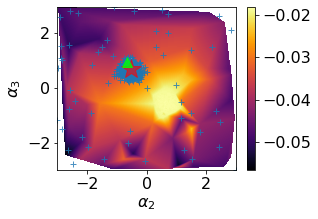

In [46]:
from matplotlib.colors import LogNorm
from matplotlib import cm
import scipy.interpolate
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# idx=5
font = {
#         'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 16}
optimization_records = np.load('../data/imgs/{}/bo{}_data.npy'.format(env_name, idx), allow_pickle=True)
matplotlib.rc('font', **font)
alpha_id = [2,3]  # select plotted alphas here
z=[]
x=[]
y=[]
for i, res in enumerate(optimization_records):
#     print("Iteration {}: \n\t{}".format(i, res))
    z.append(res['target'])
    x.append(res['params']['alpha_{}'.format(str(alpha_id[0]))])
    y.append(res['params']['alpha_{}'.format(str(alpha_id[1]))])

x=np.array(x)
y=np.array(y)
z=np.array(z)

# the optimal point found by BO
x_bo = x[np.argmax(z)]
y_bo = y[np.argmax(z)]

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
grid_x, grid_y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
values = scipy.interpolate.griddata((x, y), z, (grid_x, grid_y), method='linear')
plt.figure(figsize=(4,3))
plt.imshow(values, origin='lower', extent=[xmin, xmax, ymin, ymax],
          aspect='auto', cmap='inferno')
plt.plot(x,y, '+', alpha=0.8)
plt.xlabel(r'$\alpha_{}$'.format(str(alpha_id[0])))
plt.ylabel(r'$\alpha_{}$'.format(str(alpha_id[1])))
plt.colorbar()
print(x_bo, y_bo)
plt.scatter(x_bo, y_bo, s=600, marker="*", c='white')
# plt.scatter(*true_alpha, s=300, marker=".", c='red', alpha=0.8)
plt.plot(x_bo, y_bo, "*", c='red', markersize=20, alpha=0.6)
print(*true_alpha)
plt.plot(*true_alpha[alpha_id], '^', c='lime', markersize=10, alpha=0.8)

plt.savefig('../data/imgs/{}/bo{}.pdf'.format(env_name, idx), bbox_inches='tight')
plt.show()


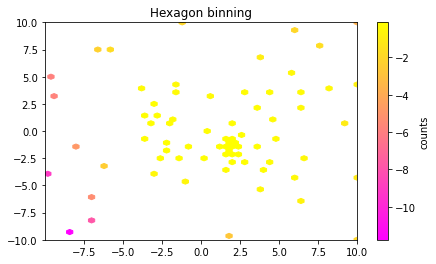

In [117]:
from matplotlib.colors import LogNorm
from matplotlib import cm

z=[]
x=[]
y=[]
for i, res in enumerate(optimization_records):
#     print("Iteration {}: \n\t{}".format(i, res))
    z.append(res['target'])
    x.append(res['params']['alpha_0'])
    y.append(res['params']['alpha_1'])
# x = y = np.linspace(-10, 10, 300)
# X, Y = np.meshgrid(x, y)
# x = X.ravel()
# y = Y.ravel()
x=np.array(x)
y=np.array(y)
z=np.array(z)
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
fig, axs = plt.subplots(ncols=1, sharey=True, figsize=(7, 4))
# fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs # ax = axs[k]
hb = ax.hexbin(x, y, C=z, gridsize=50, cmap='spring', bins=None)  # 'inferno'
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
# plt.colorbar()
plt.show()

In [49]:
import torch
t = torch.tensor([[1,2],[3,4]])
torch.gather(t, 1, torch.tensor([[0],[1]]))

tensor([[1],
        [4]])